In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
from nltk.stem.snowball import PorterStemmer

## Data preprocessing
---

We will use the Cornell Movie Review Dataset as offered by the `nltk` package: 

In [ ]:
nltk.download('movie_reviews', quiet=True)

Each review corresponds to a `file_id` which we are going to utilize to create two lists of strings; one for reviews and one for the sentiment label:

In [2]:
x = [' '.join(movie_reviews.words(file_id)) for file_id in movie_reviews.fileids()]
y = [movie_reviews.categories(file_id)[0] for file_id in movie_reviews.fileids()]

We split our data to 80% training and 20% testing sets:

In [3]:
y = [0 if label == 'neg' else 1 for label in y]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Before applying any feature selections it is worth noting the number of features in the raw training dataset:

In [4]:
baseline_vectorizer = TfidfVectorizer()

x_train_tfidf_raw = baseline_vectorizer.fit_transform(x_train)
x_train_tfidf_raw.shape

(1600, 36246)

We notice how our dataset consists of roughly 36k features through the TF-IDF modeling.

## Feature selection and extraction
---

We will apply stopword filtering, as well as stemming to the remaining tokens aiming to decrease the dimensionality of our problem. In addition, we will include words with document frequency larger than 25% and ignore words with less than 100 occurencies:

In [5]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

stemmer = PorterStemmer()

def stopword_and_stem_tokenizer(corpus):
    """
    Custom tokenizer function to be passed in TfidfVectorizer.
    Ignores english stopwords and applies stemming to remaining tokens.
    """
    tokens = [word for sentence in nltk.word_tokenize(corpus) for word in nltk.word_tokenize(sentence)]
    valid_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token): # ignore non-alphabetic characters
            valid_tokens.append(token)
    result = [stemmer.stem(t) for t in valid_tokens if t not in stopwords.words('english')]
    return result

Applying the above tokenizer to the `TfidfVectorizer` we get:

In [6]:
optimized_vectorizer = TfidfVectorizer(max_df=0.25, min_df=100, tokenizer=stopword_and_stem_tokenizer)
x_train_tfidf = optimized_vectorizer.fit_transform(x_train)
x_test_tfidf = optimized_vectorizer.transform(x_test)
x_train_tfidf.shape

(1600, 720)

We notice how the number of features after the feature selection and extraction is decreased to roughly 720.

## Classifiers
---

We will evaluate the TF-IDF modeling by training two distinct classifiers and comparing the resulting precision, recall, F1 and AUC scores. Since there is no built-in method to calculate the AUC score for every class, we will use a custom function:

In [11]:
def calculate_class_AUC_score(y_true, y_pred, label):
    """
    Calculates AUC scores for the given class label.
    """
    precision = [0, _, 1]
    recall = [1, _, 0]
    cr = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    precision[1] = cr[label]['precision']
    recall[1] = cr[label]['recall']
    auc_score = auc(recall, precision)
    return auc_score

### A. Dummy Classifier

In [17]:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(x_train_tfidf, y_train)

# train: precision, recall, f1
predictions_train = dummy_clf.predict(x_train_tfidf)
print('Training set')
print('============')
print(classification_report(y_train, predictions_train, zero_division=0))

# train: auc
auc_class0_train = calculate_class_AUC_score(y_train, predictions_train, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_train))
auc_class1_train = calculate_class_AUC_score(y_train, predictions_train, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_train))
print('macro-average AUC: {0:.3f}'.format((auc_class0_train + auc_class1_train)/2))

Training set
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       801
           1       0.49      0.49      0.49       799

    accuracy                           0.50      1600
   macro avg       0.50      0.50      0.50      1600
weighted avg       0.50      0.50      0.50      1600

class 0 AUC: 0.500
class 1 AUC: 0.491

macro-average AUC: 0.496


We move on to the testing set:

Testing set
              precision    recall  f1-score   support

           0       0.50      0.47      0.48       199
           1       0.51      0.54      0.52       201

    accuracy                           0.51       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.50      0.51      0.50       400

class 0 AUC: 0.485
class 1 AUC: 0.525

macro-average AUC: 0.505


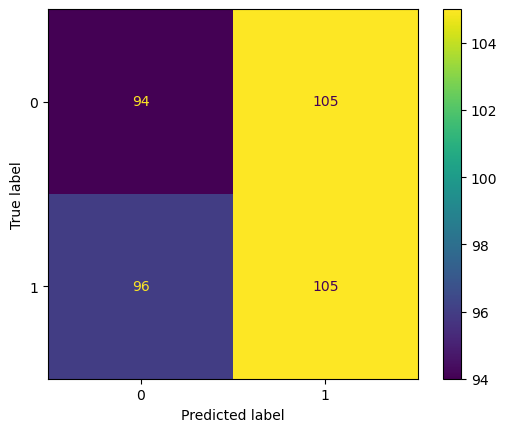

In [18]:
# test: precision, recall, f1
predictions_test = dummy_clf.predict(x_test_tfidf)
print('Testing set')
print('===========')
print(classification_report(y_test, predictions_test, zero_division=0))

# test: auc
auc_class0_test = calculate_class_AUC_score(y_test, predictions_test, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_test, predictions_test, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

# test: confusion matrix
ConfusionMatrixDisplay.from_estimator(dummy_clf, x_test_tfidf, y_test, values_format='.0f')
plt.show()

### B. Logistic Regression

In [36]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
}

logistic_clf = LogisticRegression(solver="liblinear")
gscv = GridSearchCV(logistic_clf, parameters, cv=10)
gscv.fit(x_train_tfidf, y_train)

# train: precision, recall, f1
predictions_train = gscv.predict(x_train_tfidf)
print('Training set')
print('============')
print(classification_report(y_train, predictions_train))

# train: auc
auc_class0_train = calculate_class_AUC_score(y_train, predictions_train, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_train))
auc_class1_train = calculate_class_AUC_score(y_train, predictions_train, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_train))
print('macro-average AUC: {0:.3f}'.format((auc_class0_train + auc_class1_train)/2))

Training set
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       801
           1       0.89      0.91      0.90       799

    accuracy                           0.90      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.90      0.90      0.90      1600

class 0 AUC: 0.903
class 1 AUC: 0.905

macro-average AUC: 0.904


In [37]:
gscv.best_params_

{'C': 1.0, 'penalty': 'l2'}

We notice how the best parameters calculated from `GridSearch` are `C=1.0` and `penalty=l2`. We move on to the testing set:

Testing set
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       199
           1       0.79      0.81      0.80       201

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

class 0 AUC: 0.789
class 1 AUC: 0.796

macro-average AUC: 0.793


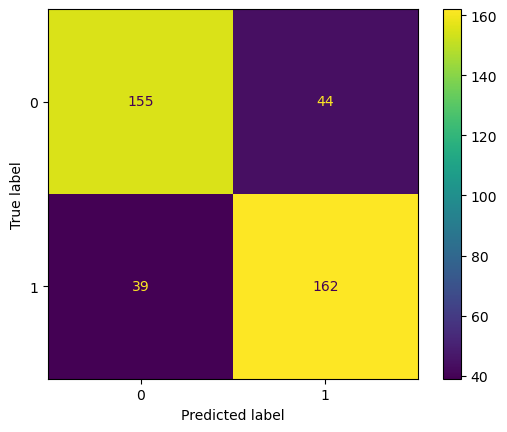

In [38]:
# test: precision, recall, f1
predictions_test = gscv.predict(x_test_tfidf)
print('Testing set')
print('===========')
print(classification_report(y_test, predictions_test))

# test: auc
auc_class0_test = calculate_class_AUC_score(y_test, predictions_test, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_test, predictions_test, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

# test: confusion matrix
ConfusionMatrixDisplay.from_estimator(gscv, x_test_tfidf, y_test, values_format='.0f')
plt.show()

### C. Naive Bayes

In [39]:
parameters = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
}

bayes_clf = MultinomialNB()
gscv = GridSearchCV(bayes_clf, parameters, cv=10)
gscv.fit(x_train_tfidf, y_train)

# train: precision, recall, f1
predictions_train = gscv.predict(x_train_tfidf)
print('Training set')
print('============')
print(classification_report(y_train, predictions_train))

# train: auc
auc_class0_train = calculate_class_AUC_score(y_train, predictions_train, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_train))
auc_class1_train = calculate_class_AUC_score(y_train, predictions_train, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_train))
print('macro-average AUC: {0:.3f}'.format((auc_class0_train + auc_class1_train)/2))

Training set
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       801
           1       0.84      0.84      0.84       799

    accuracy                           0.84      1600
   macro avg       0.84      0.84      0.84      1600
weighted avg       0.84      0.84      0.84      1600

class 0 AUC: 0.840
class 1 AUC: 0.839

macro-average AUC: 0.839


In [40]:
gscv.best_params_

{'alpha': 0.0001}

We notice how the best parameter calculated from GridSearch is `alpha=0.0001`. We move on to the testing set:

Testing set
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       199
           1       0.77      0.75      0.76       201

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400

class 0 AUC: 0.766
class 1 AUC: 0.760

macro-average AUC: 0.763


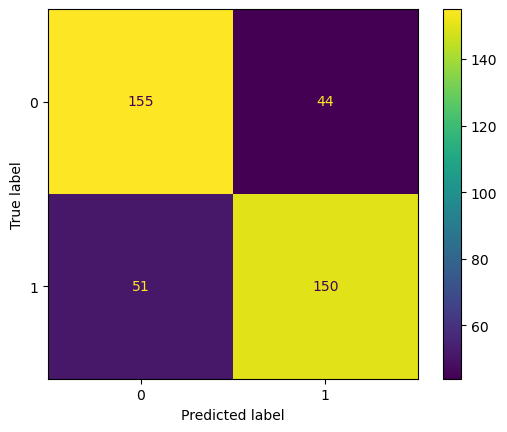

In [41]:
# test: precision, recall, f1
predictions_test = gscv.predict(x_test_tfidf)
print('Testing set')
print('===========')
print(classification_report(y_test, predictions_test))

# test: auc
auc_class0_test = calculate_class_AUC_score(y_test, predictions_test, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_test, predictions_test, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

# test: confusion matrix
ConfusionMatrixDisplay.from_estimator(gscv, x_test_tfidf, y_test, values_format='.0f')
plt.show()

## Learning curves
---

As a last step we will plot the learning of the classifiers used in this exercise:

In [47]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Helper function for plotting classifier learning curves.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='f1', train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color="orange")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="cross-validation")

    plt.legend(loc="lower right")
    
    return plt

For the logistic regression we get:

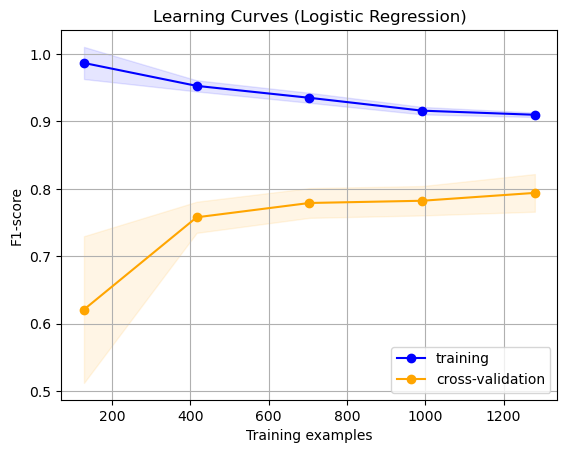

In [52]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(logistic_clf, title, x_train_tfidf, y_train, cv=cv, n_jobs=-1)
plt.show()

For the naive Bayes we get:

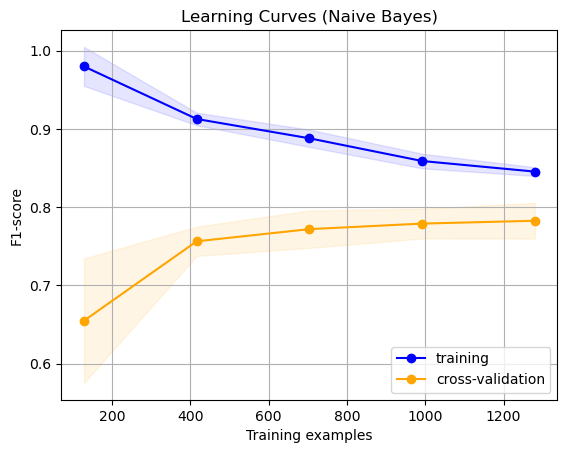

In [46]:
title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(bayes_clf, title, x_train_tfidf, y_train, cv=cv, n_jobs=-1)
plt.show()